In [2]:
#No55(混同行列の作成）

#NO54までのコード
import pandas as pd
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
drive.mount('/content/drive')
!wget https://archive.ics.uci.edu/static/public/359/news+aggregator.zip
!unzip news+aggregator.zip
df = pd.read_csv("./newsCorpora.csv",sep="\t",header=None,names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])
#「PUBLISHER」の行から、”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
#isinはあくまでbool値を返すことに注意(Trueが抽出される)
df = df[df["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]
#「TITLE」と「CATEGORY」の列を抽出する．
df = df[["TITLE", "CATEGORY"]]
#学習、検証、評価データに分割する(分割したいもの、割合、shuffleはTrueがデフォルト)
#まず0.9:0.1で分ける
train, test = train_test_split(df, test_size=0.2)
#次に0.2を半分にする(検証、評価データを0.1にする)
test, valid = train_test_split(test, test_size=0.5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2024-06-07 14:10:28--  https://archive.ics.uci.edu/static/public/359/news+aggregator.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘news+aggregator.zip.1’

news+aggregator.zip     [           <=>      ]  27.87M  11.1MB/s    in 2.5s    

2024-06-07 14:10:31 (11.1 MB/s) - ‘news+aggregator.zip.1’ saved [29224203]

Archive:  news+aggregator.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
def preprosessing(text):
    #string.punctuation 「'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'」のこと
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    #maketransで作成したtableを文字列を変換する
    text = text.translate(table)
    #小文字にする
    text = text.lower()
    #正規表現を利用するために、compileを用いてpatternを作成する
    pattern = re.compile('[0-9]+')
    #正規表現にマッチした部分に0を代入
    text = re.sub(pattern, '0', text)

    return text

#データの連結、前処理
df = pd.concat([train, valid, test], axis = 0)
#もとのindexを削除
df.reset_index(drop=True, inplace=True)

df['TITLE'] = df['TITLE'].map(lambda x: preprosessing(x))
#データの連結、前処理
df = pd.concat([train, valid, test], axis = 0)
df.reset_index(drop=True, inplace=True)
#map関数　シーケンスの構成要素すべてに対して、ある関数の処理を行わせるという高階関数
#lambda関数を用いて、xを引数として、preprosessing関数を呼び出す
df['TITLE'] = df['TITLE'].map(lambda x: preprosessing(x))
vec_tfidf = TfidfVectorizer() #TfidfVectorizerのインスタンス生成
data = vec_tfidf.fit_transform(df['TITLE'])
data = pd.DataFrame(data.toarray(), columns = vec_tfidf.get_feature_names_out())
#整数除算をして、dataを分割する。
split_point1 = int(len(data)//3)
split_point2 = int(split_point1 * 2)
#学習、検証、評価データ
x_train = data[:split_point1]
x_valid = data[split_point1:split_point2]
x_test = data[split_point2:]
#学習、検証、評価等別
y_data = df['CATEGORY']
y_train = y_data[:split_point1]
y_valid = y_data[split_point1:split_point2]
y_test = y_data[split_point2:]

In [4]:
from sklearn.linear_model import LogisticRegression
#ロジスティック回帰モデルのインスタンス生成
model = LogisticRegression()
#訓練の実行(学習データ、ラベル(正解))
model.fit(x_train, y_train)

LogisticRegression()

In [5]:
# 正解率計算用のメソッド
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_valid)
#訓練データとテストデータを用いて予測する
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

Confusion matrix (train)
: [[1849   18    0    7]
 [   6 1763    0    2]
 [  34   79  181    6]
 [  86   59    0  356]]


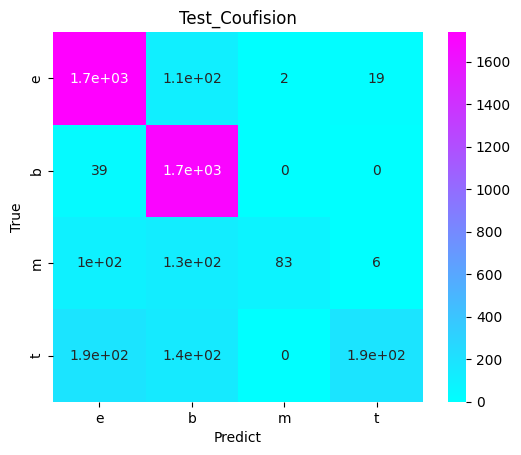

In [6]:
#True Positive   正例を正しく正例として判別できるケース
#対角上にあるものが正しく判別できたケース

#scikit-learnの混同行列の作成のためのモジュール
from sklearn.metrics import confusion_matrix
#seabornのimport(snsはSamuel Norman Seabornに由来しているらしい)
import seaborn as sns
#matplotlibのimport
import matplotlib.pyplot as plt
#学習データの混同行列の作成
print(f'Confusion matrix (train)\n: {confusion_matrix(y_train, y_train_pred)}')
#テストデータの混同行列(ヒートマップ)の作成
hm = confusion_matrix(y_test, y_test_pred)
hm = pd.DataFrame(data=hm, index=["e", "b", "m", "t"], columns=["e", "b", "m", "t"])
# square：枠を正方形にする　cbar：数値の大小を表す棒を表示　annot：boxの数字を表示 cmap：カラーコード選択
sns.heatmap(hm, square=True, cbar=True, annot=True, cmap="cool")
#ラベルの付与
plt.xlabel("Predict")
plt.ylabel("True")
#タイトルの付与
plt.title("Test_Coufision")
#ヒートマップの保存
plt.savefig("Heatmap.png")